In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['realreal', 'fivecat', 'ccccccccc', 'dfdfdf', 'aaaaaaaaa']


In [2]:
v2f = '../input/fivecat/chinese_count.csv'
aa = pd.read_csv(v2f)
bb = aa.loc[aa['word_len']!=0,['business_id', 'stars', 'clean', 'food', 'price', 'service', 'time', 'word_len','text']]
bb['n_c'] = bb['clean']/bb['word_len']
bb['n_f'] = bb['food']/bb['word_len']
bb['n_p'] = bb['price']/bb['word_len']
bb['n_s'] = bb['service']/bb['word_len']
bb['n_t'] = bb['time']/bb['word_len']
cc = bb[['business_id','stars','n_c','n_f','n_p','n_s','n_t','text']]

bus[bus['business_id']==9853]

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (2,3,6,9,19,25,54,57,58,60,64,65,80,86) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.631414
[200]	valid_0's rmse: 0.628828
[300]	valid_0's rmse: 0.627505
Early stopping, best iteration is:
[265]	valid_0's rmse: 0.626964
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.645516
[200]	valid_0's rmse: 0.648136
Early stopping, best iteration is:
[107]	valid_0's rmse: 0.64515
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.64048
[200]	valid_0's rmse: 0.643049
Early stopping, best iteration is:
[132]	valid_0's rmse: 0.63949
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.604552
Early stopping, best iteration is:
[73]	valid_0's rmse: 0.603082
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 0.656259
Early stopping, best iteration is:
[49]	valid_0's rmse: 0.653701


Text(0.5, 1.0, 'LightGBM - Feature Importance')

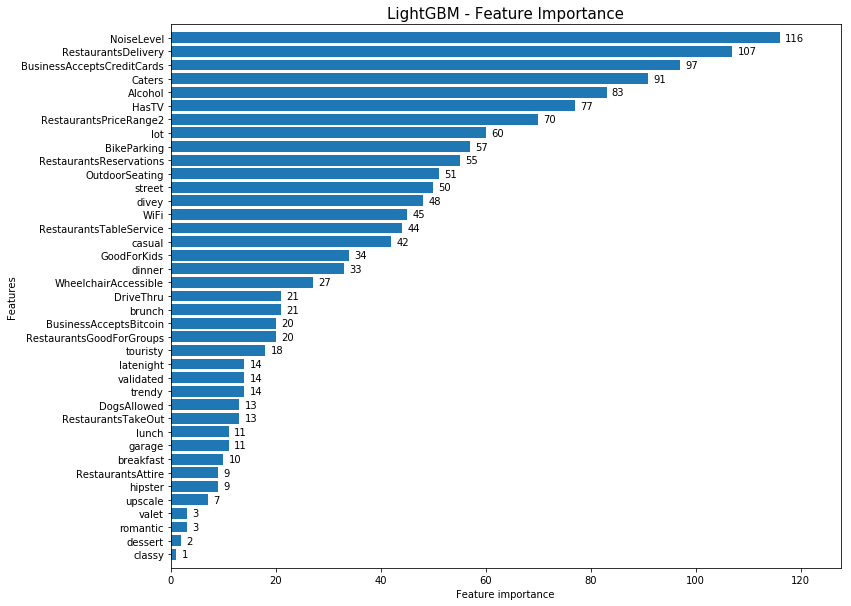

In [4]:
path_train_bus = "../input/aaaaaaaaa/business_train.json"
v2r = '../input/realreal/real'
v2h = '../input/dfdfdf/df_hours'
v2c = '../input/dfdfdf/df_cat'
r = pd.read_csv(v2r)
c = pd.read_csv(v2c)
bus = pd.read_json(path_train_bus, lines=True, orient="columns")
rbus = bus[['business_id']]
g = r.groupby(['business_id'])['stars'].mean().reset_index()
com = pd.concat([rbus,c],axis=1)
aa = pd.merge(g,com,on='business_id',how='left')
y = aa['stars']
bb = aa.iloc[:,2:]
from sklearn import preprocessing
lb = preprocessing.LabelEncoder()
for i in bb.columns:
    bb[i] = lb.fit_transform(bb[i].astype(str))
import lightgbm as lgb
import pandas as pd
import pickle
from sklearn import model_selection
import matplotlib.pyplot as plt



def run_lgb(train_X, train_y, val_X, val_y):
    params = {
        "objective": "regression",
        "metric": "rmse",
        "num_leaves": 30,
        "min_child_weight": 50,
        "learning_rate": 0.05,
        "bagging_fraction": 0.7,
        "feature_fraction": 0.7,
        "bagging_frequency": 5,
        "bagging_seed": 2018,
        "verbosity": -1
    }

    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100,
                      evals_result=evals_result)

    # pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return model, evals_result
#%%

train_X = bb
train_y = y

kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.iloc[dev_index, :], train_X.iloc[val_index, :]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]

    model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y)
#%%
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)




In [5]:
aa.shape

(3557, 90)

In [6]:
def img_to_sig(arr):
    """Convert a 2D array to a signature for cv2.EMD"""
    
    # cv2.EMD requires single-precision, floating-point input
    sig = np.empty((arr.size, 3), dtype=np.float32)
    count = 0
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            sig[count] = np.array([arr[i,j], i, j])
            count += 1
    return sig

In [7]:
import numpy as np
import cv2
import copy
bid = cc['business_id'].values
dic1 = {'n_c':'cleaness', 'n_f':'food', 'n_p':'price', 'n_s':'service', 'n_t':'time'}
imp = ['NoiseLevel','RestaurantsDelivery','Caters',
       'Alcohol','HasTV','RestaurantsPriceRange2','lot','BikeParking']
att = {'NoiseLevel':['quiet','None','average','loud','very_loud'],
      'RestaurantsDelivery':['None','True','False'],
      'BusinessAcceptsCreditCards':['False','True','None'],
      'Caters':['True','False','None'],
      'Alcohol':['None','full_bar','none','beer_and_wine'],
      'HasTV':['True','None','False'],
      'RestaurantsPriceRange2':['None','4','2','1','3'],
      'lot':['True','False','None'],
      'BikeParking':['None','True','False']}
def comment(b_id, n_cat=1, read=3, n_att=3, show=True):
    assert b_id in bid, 'this business_id is not in dataset, try another chinese restaurant business_id'
    at = aa[aa['business_id']==b_id]
    tt = cc[cc['business_id']==b_id]
    t1 = tt[tt['stars'].isin([1,2])]
    t2 = tt[tt['stars'].isin([4,5])]
    c = []
    res = []
    for i in ['n_c','n_f','n_p','n_s','n_t']:
        s1 = zip([1/t1.shape[0] for _ in range(t1.shape[0])],t1[i].values)
        bk1 = np.array(list(s1))
        s2 = zip([1/t2.shape[0] for _ in range(t2.shape[0])],t2[i].values)
        bk2 = np.array(list(s2))
        sig1 = img_to_sig(bk1)
        sig2 = img_to_sig(bk2)
        dist, _, flow = cv2.EMD(sig1, sig2, cv2.DIST_L2)
        ever1 = np.mean(t1[i].values)
        ever2 = np.mean(t2[i].values)
        pointer = 'good' if ever2>=ever1 else 'bad'
        res.append([i,dist,pointer,ever1,ever2])
    res.sort(key=lambda x:x[1])
    c.append(res[:])
    for i in range(n_cat):
        k = res.pop()
        c.append(dic1[k[0]])
        c.append(k[2])
        if k[2]=='good':
            temp = copy.deepcopy(t2[k[0]].values)
            for k,j in enumerate(range(read)):
                index = np.argmax(temp)
                c.append(k+1)
                c.append(t2['text'].values[index])
                temp[index]=-1
        else:
            temp = copy.deepcopy(t1[k[0]].values)
            for k,j in enumerate(range(read)):
                index = np.argmax(temp)
                c.append(k+1)
                c.append(t1['text'].values[index])
                temp[index]=-1   
    cnt=0
    for j in imp:
        if att[j][0]=='None':
            if at[j].values[0] not in ['None',att[j][1]]:
                c.append([j,at[j].values[0],att[j][1]])
                cnt+=1
                if cnt==n_att:
                    break
        else:
            if at[j].values[0] != att[j][0]:
                c.append([j,at[j].values[0],att[j][0]])
                cnt+=1
                if cnt==n_att:
                    break
    return c
        
        
        

In [ ]:
print(815, 8182)

In [8]:
vb = comment(9853, n_cat=2, read=2, n_att=2)
vb

[[['n_s', 3.716869354248047, 'bad', 0.03782944237357934, 0.03390234837294006],
  ['n_f', 3.8199026584625244, 'bad', 0.13920012103156856, 0.12997937811023608],
  ['n_c',
   9.344343185424805,
   'bad',
   0.010809025930021657,
   0.009268965563802314],
  ['n_p', 10.230628967285156, 'bad', 0.04796537198641409, 0.01500544233497749],
  ['n_t',
   12.201942443847656,
   'bad',
   0.03248122253129495,
   0.023117141894874894]],
 'time',
 'bad',
 1,
 "I have to state that I'm hard on Chinese food because I've had plenty of delicious gourmet, authentic Chinese food in the bay area, LA, and China.\n\nLet me set the stage with a couple words: No chopsticks.\n\nThis restaurant caters to non Asians, which is fine for some people but not my style.  How can a Chinese restaurant not have chopsticks in their place settings?  If you're looking for delicious and authentic, this is not the place.  If you're looking for a Panda Express equivalent in a nicer restaurant setting that serves alcohol, then thi

In [ ]:
com[com['business_id']==9853]

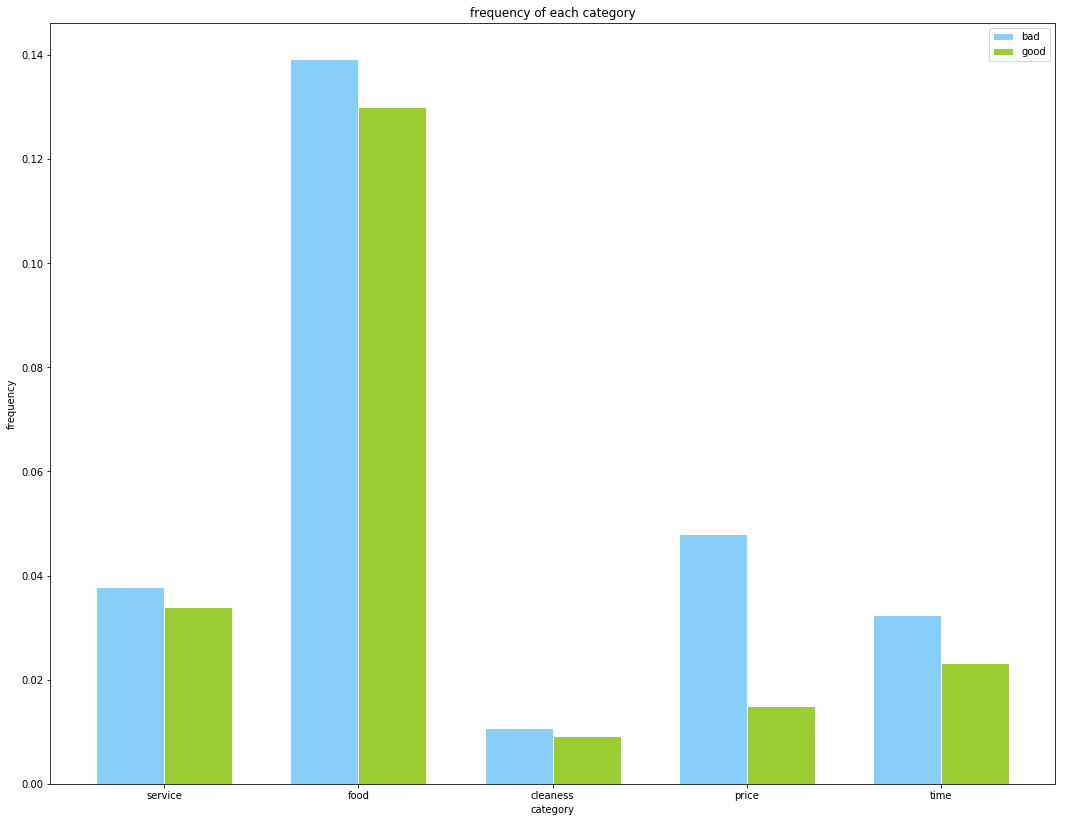

In [10]:
res = []
res1 = []
res2 = []
X = np.array([1,2,3,4,5])
for i in range(5):
    a = vb[0][i][3]
    b = vb[0][i][4]
    c = vb[0][i][0]
    res.append(a)
    res1.append(b)
    res2.append(c)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18,14))
plt.bar(X,res,width = 0.35,facecolor = 'lightskyblue',edgecolor = 'white',label='bad')
#width:柱的宽度
plt.bar(X+0.35,res1,width = 0.35,facecolor = 'yellowgreen',edgecolor = 'white',label='good')
###
plt.xlabel('category')  
plt.ylabel('frequency')  
plt.title('frequency of each category')  
plt.xticks(X+0.35/2,labels=['service','food','cleaness','price','time'])
plt.legend()

In [11]:
?plt.xticks

In [ ]:
def f(b_id):
    res = ['cfpst']
    for i in ['n_c','n_f','n_p','n_s','n_t']:
        tt = cc[cc['business_id']==b_id]
        t1 = tt[tt['stars'].isin([1,2])]
        t2 = tt[tt['stars'].isin([4,5])]
        s1 = zip([1/t1.shape[0] for _ in range(t1.shape[0])],t1[i].values)
        bk1 = list(s1)
        bk1 = np.array(bk1)
        s2 = zip([1/t2.shape[0] for _ in range(t2.shape[0])],t5[i].values)
        bk2 = list(s2)
        bk2 = np.array(bk2)
        sig1 = img_to_sig(bk1)
        sig2 = img_to_sig(bk2)
        dist, _, flow = cv2.EMD(sig1, sig2, cv2.DIST_L2)
        res.append(dist)
    return(res)

In [ ]:
sam = cc[cc['business_id']==9853]
sb = sam[sam['stars'].isin([1,2])]
list(sb['n_t'].values).index(max(list(sb['n_t'].values)))

In [ ]:
aa[aa['business_id']==9853].iloc[27,:]


In [ ]:
 ['NoiseLevel', 'average', 'quiet'],

In [ ]:
bins = np.nanpercentile(train_df["sum_merch_trans"], range(0,101,10))
train_df['binned_sum_merch_trans'] = pd.cut(train_df['sum_merch_trans'], bins)
#cnt_srs = train_df.groupby("binned_sum_hist_trans")[target_col].mean()

plt.figure(figsize=(12,8))
sns.boxplot(x="binned_sum_merch_trans", y=target_col, data=train_df, showfliers=False)
plt.xticks(rotation='vertical')
plt.xlabel('binned sum of new merchant transactions', fontsize=12)
plt.ylabel('Loyalty score', fontsize=12)
plt.title("Sum of New merchants transaction value (Binned) distribution")
plt.show()

In [ ]:
len(hh['n_t'])

In [ ]:

bins = np.nanpercentile(hh['n_t'].values, range(0,101,10),duplicates=False)
hh['newtime'] = pd.cut(hh['n_t'],bins)

In [ ]:
hhg = hh[hh['stars'].isin([4,5])]['n_t']
hhg.to_csv(hhg,index = False)
hhg = hh[hh['stars'].isin([1,2])]['n_t']
hhb.to_csv(hhb,index = False)